<h1 style="color:#b01e3a;">Diabetes Risk Prediction</h2>

Prediction of diabetis risk based on the healthcare indicators. Machine learning project.

__Table of Contents__

1. [About the project](#about)
2. [Load data](https://github.com/nadia-paz/cdc_diabetes/blob/main/notebook.ipynb#loaddata)
3. [Exploratory Data Analysis](#eda)
4. Creating and Tuning ML models
    - Logistic Regression
    - Decision Tree
    - Random Forest
    - XGBoost
5. Training the Final model

<a name="about"></a> 
### About the project

> The project involves working with BRFSS data from CDC. The Behavioral Risk Factor Surveillance System (BRFSS) is a health-related telephone survey that collects data about US residents' health-related risk behaviors, chronic health conditions, and use of preventive services. If you want to learn more about the data and its source, please refer to the `Readme` file of the project. <br>

- The main objective of the project is to develop a __machine-learning model__ that can *predict the risk of developing diabetes based on health indicators*. 
- As a secondary objective, this project aims to make a positive impact on people's lives by using the power of machine learning to predict the risks of developing diabetes. By analyzing health indicators and risk behaviors, I hope to create a model that can help individuals take proactive steps toward their health and well-being.


In [18]:
# imports
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

from scipy import stats 
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import FunctionTransformer
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

import pickle

# load data preparation module
import src.data_prep as dp
import src.explore as ex
import src.model as md

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
from importlib import reload

<a class="anchor" id="loaddata"></a>
### Load data

The data preparation code is located in the `data_prep.py` file in the `src` directory. It loads data, drops duplicates, converts data types, and splits data into `train`, `validation`, and `test` sets.

In [4]:
# load the data
df = dp.acquire()
df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
0,1,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,0,9,4,3,0
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,0,7,6,1,0
2,1,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,0,9,4,8,0
3,1,0,1,27,0,0,0,1,1,1,...,0,2,0,0,0,0,11,3,6,0
4,1,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,0,11,5,4,0


Upon initial inspection, the data appeared to mostly consist of digital values and was prepared for machine learning. However, it was not user-friendly for data exploration. Based on the data dictionary provided in the `Readme` file I replaced numerical values in categorical columns with human-readable information. This makes the process of data exploration easier. Those changes only impact `df_explore` data frame, which excludes any data from the `test` data set, and leaves the original data untouched as well.

<div class="alert alert-success">

<a name="eda"></a> 
### Exploratory Data Analysis

In [4]:
df_explore = dp.split_data(df, explore=True)
df_explore.head(3).T

,0,1,2
HighBP,Normal Blood Pressure,Normal Blood Pressure,Normal Blood Pressure
HighChol,High Cholesterol,Normal Cholesterol,High Cholesterol
CholCheck,Had Cholesterol Check,Had Cholesterol Check,Had Cholesterol Check
BMI,42,27,35
Smoker,Not a Smoker,Not a Smoker,Smoker
Stroke,Didn't Have a Stroke,Didn't Have a Stroke,Didn't Have a Stroke
HeartDiseaseorAttack,No Heart Disease,No Heart Disease,No Heart Disease
PhysActivity,No Physical Activity - 30 days,No Physical Activity - 30 days,Active in the past 30 days
Fruits,Eats at least 1 friut a day,Eats at least 1 friut a day,Eats at least 1 friut a day
Veggies,Eats at least 1 vegetable a day,Eats at least 1 vegetable a day,Eats at least 1 vegetable a day


In [5]:
df_explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183579 entries, 0 to 183578
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   HighBP                183579 non-null  object
 1   HighChol              183579 non-null  object
 2   CholCheck             183579 non-null  object
 3   BMI                   183579 non-null  int64 
 4   Smoker                183579 non-null  object
 5   Stroke                183579 non-null  object
 6   HeartDiseaseorAttack  183579 non-null  object
 7   PhysActivity          183579 non-null  object
 8   Fruits                183579 non-null  object
 9   Veggies               183579 non-null  object
 10  HvyAlcoholConsump     183579 non-null  object
 11  AnyHealthcare         183579 non-null  object
 12  NoDocbcCost           183579 non-null  object
 13  GenHlth               183579 non-null  int64 
 14  MentHlth              183579 non-null  int64 
 15  PhysHlth         

#### Target variable

Let's have a look on our target variable - Diabetes. What percentage of people represented in our data have diabetes?

In [6]:
df_explore.Diabetes.value_counts(normalize=True)

Diabetes
No Diabetes   0.847
Diabetes      0.153
Name: proportion, dtype: float64

- 84.7% of respondents don't have Diabetes
- 15.3% of respondets have Diabetes condition.

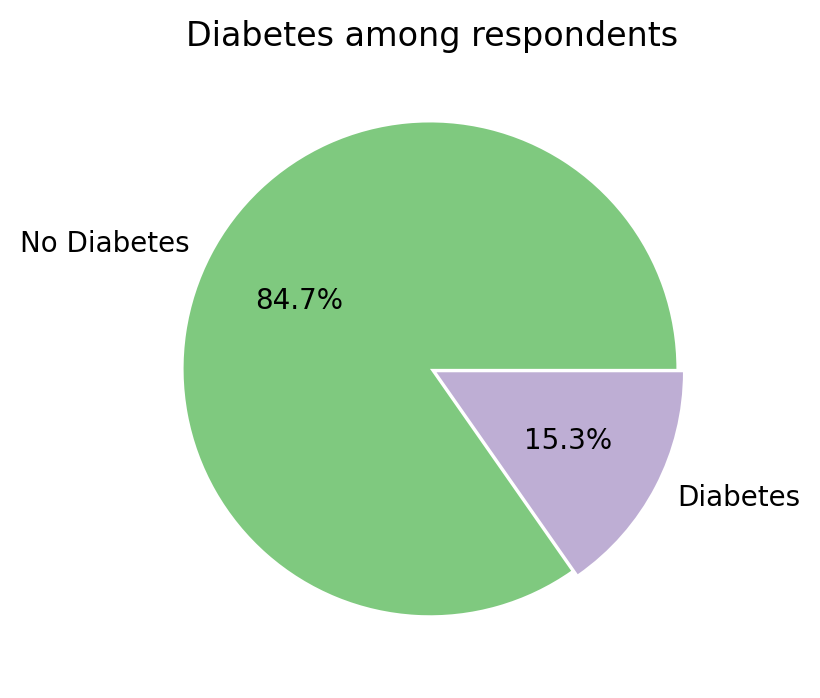

In [13]:
# visualize 
ex.diabetes_piechart(df_explore, 'Diabetes')

#### BMI (body mass index)

The next step is to find out whether there is a difference in BMI between healthy individuals and those with diabetes. We know that overweight people are more susceptible to type II diabetes. Therefore, we need to analyze our data to determine if our findings align with this trend. A normal BMI range is considered to be between 18.5 and 24.9. Anything below 18.5 is classified as underweight, and anything above 24.9 is considered overweight. To facilitate our exploration, let's begin by splitting our data.

In [7]:
# get descriptive statistics about BMI
df_explore.BMI.describe()[1:]

mean   28.691
std     6.807
min    12.000
25%    24.000
50%    27.000
75%    32.000
max    98.000
Name: BMI, dtype: float64

In [8]:
# create 2 data frames for ppl with diabetis and without
healthy = df_explore.query('Diabetes_binary == 0')
diabetes = df_explore.query('Diabetes_binary == 1')

In [9]:
# check if the split is correct
healthy.Diabetes.unique(), diabetes.Diabetes.unique()

(array(['No Diabetes'], dtype=object), array(['Diabetes'], dtype=object))

In [10]:
# min, average and max BMI for healthy ppl
healthy.BMI.min(), healthy.BMI.mean(), healthy.BMI.max()

(12, 28.092849334447944, 98)

In [11]:
# min, average and max BMI for ppl with diabetes
diabetes.BMI.min(), diabetes.BMI.mean(), diabetes.BMI.max()

(13, 32.00181695108483, 98)

Although the min and max are almost the same, the average BMI is almost 4 points higher for people with diabetes.

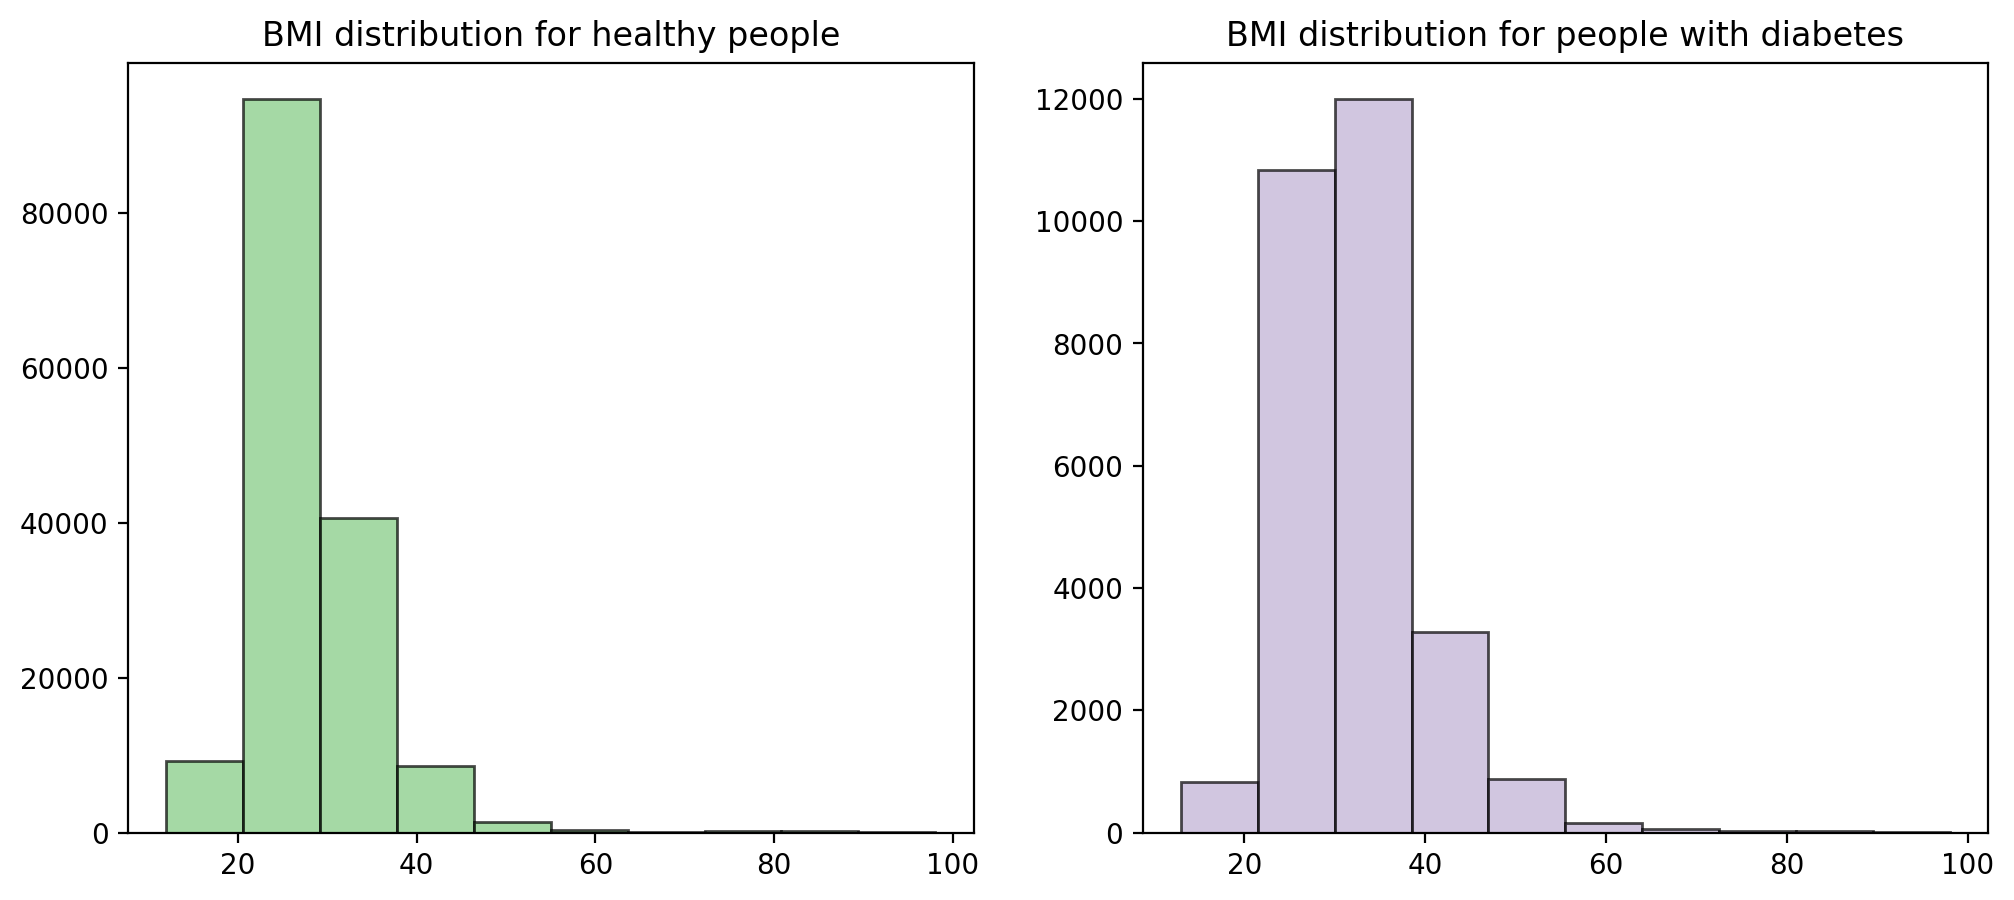

In [12]:
# visualize BMI distribution among people with and without diabetes
ex.bmi_distribution(healthy, diabetes)

The visual confirm that people with diabetes tend to have higher BMIs.

In [13]:
# create data frames for underweigh, overweight and normal weight
under = df_explore.query('BMI <= 18')
normal = df_explore.query('BMI > 18 and BMI < 25')
over = df_explore.query('BMI >= 25')

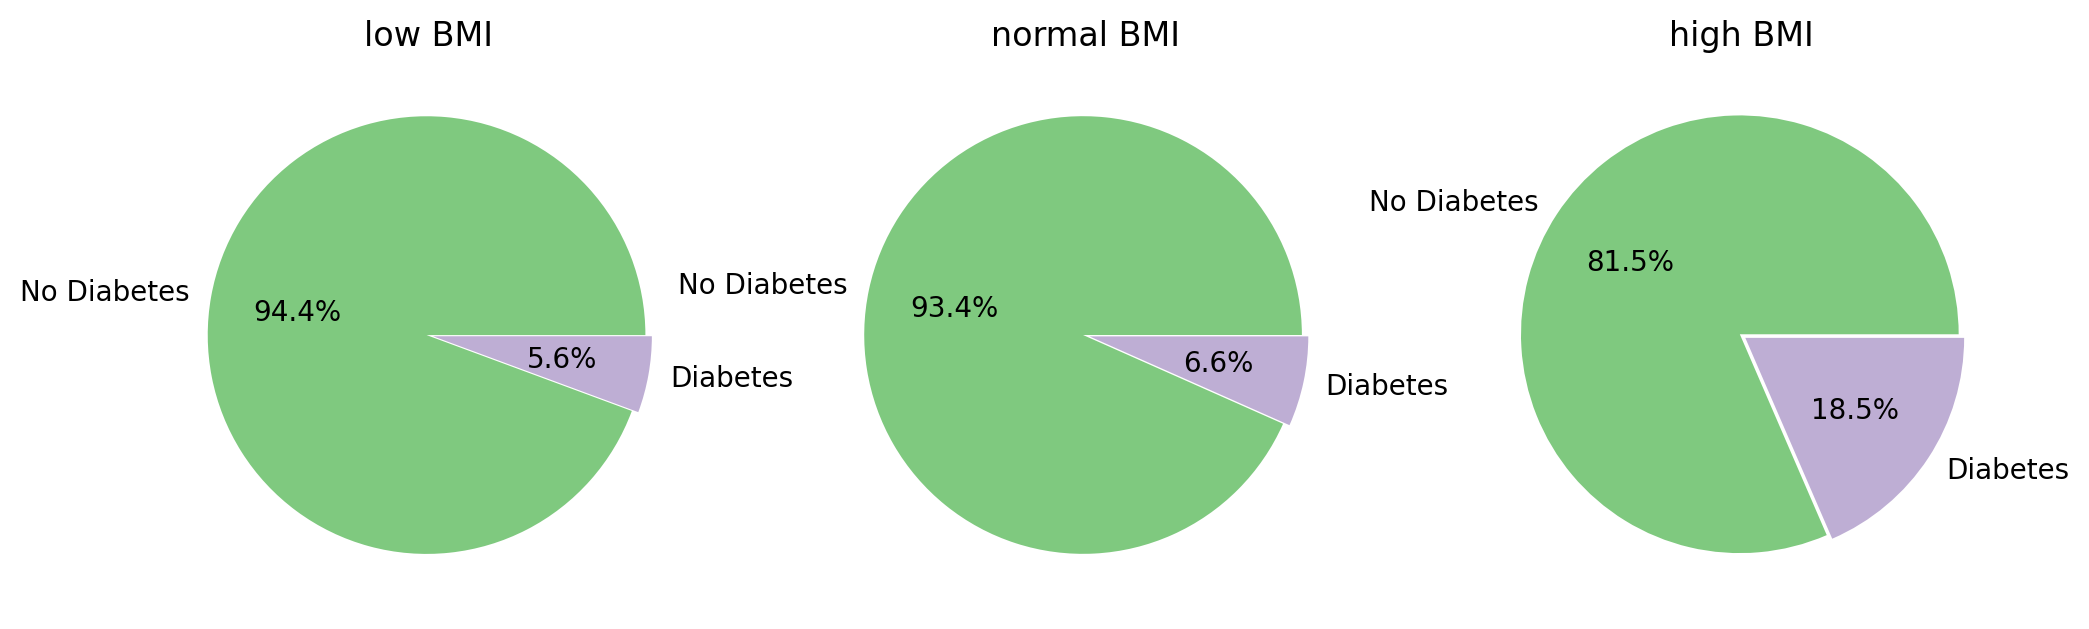

In [21]:
ex.bmi_piechart(under, normal, over)

#### Mental health and physical health

Both columns `MentHlth` (mental health) and `PhysHlth` (physical health) contain values ranging from 1 to 31 that represent the number of days with poor menthal or physical health. Let's compare those numbers by plotting relative distributions for two groups: diabetes and healthy. 

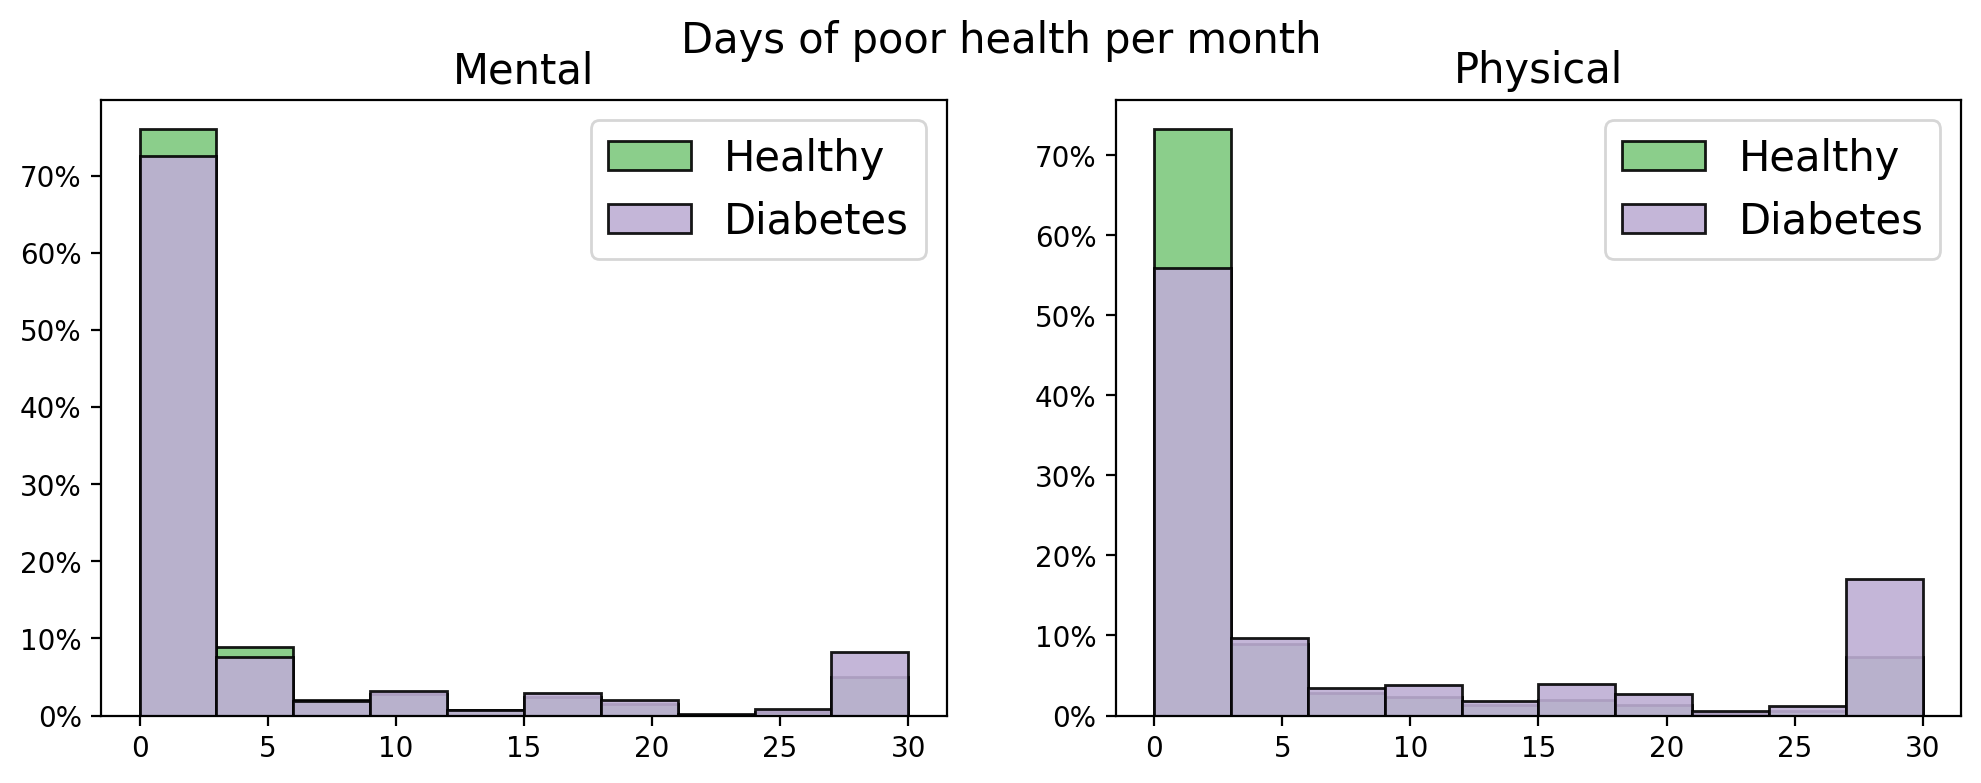

In [14]:
ex.sick_days_viz(healthy, diabetes)

 We can see that reported poor physical health days differ a lot in both groups, while menthal health values are almost the same. Furthermore, both this features look more categorical than numerical. On the next visualization, I reduce the number of categories to three and we can clearly observe the same tendency as on the previous image. Prior data preprocessing I'll create 3 categories in both features.

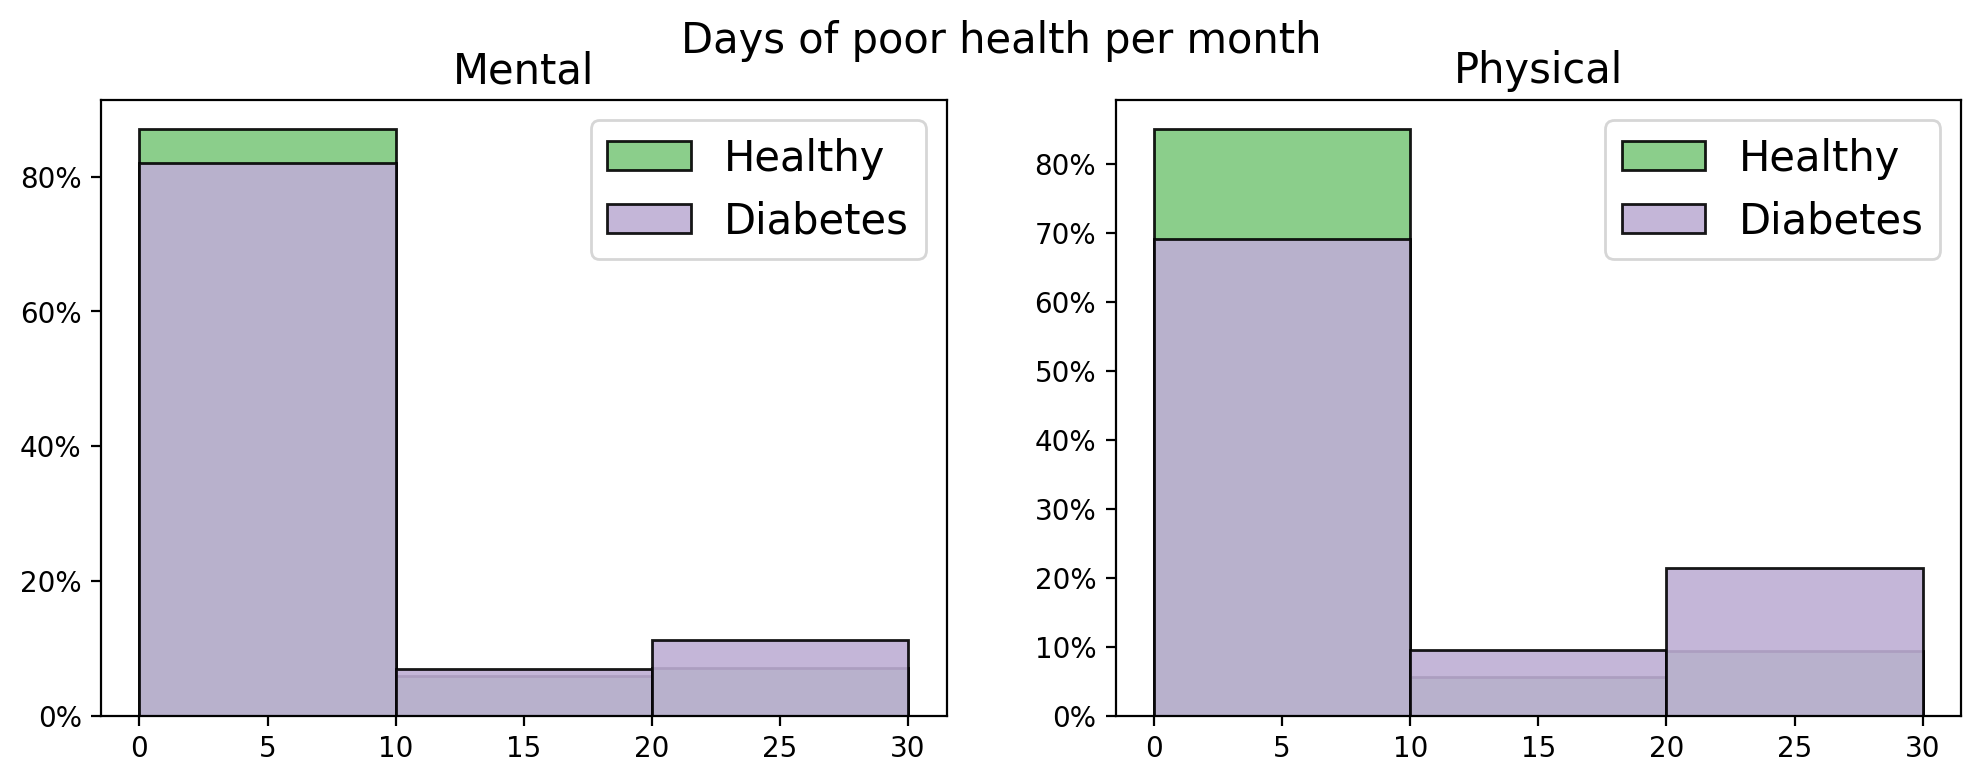

In [23]:
ex.sick_days_viz_bins(healthy, diabetes, 3)

In [24]:
# split by categories
pd.cut(df_explore.MentHlth, bins=3, labels=['low', 'medium', 'high']).value_counts()

MentHlth
low       163539
high       11424
medium      8616
Name: count, dtype: int64

In [25]:
# same but with pysical health
pd.cut(df_explore.PhysHlth, bins=3, labels=['low', 'medium', 'high']).value_counts()

PhysHlth
low       156174
high       17946
medium      9459
Name: count, dtype: int64

#### Categorical features

Most of columns in our data contain categorical data. As a first same of exploring categorical features, I'd like to plot the data from the `Age` column to see if I can reduce the number of categories from 13 to 4, 5 or 6.

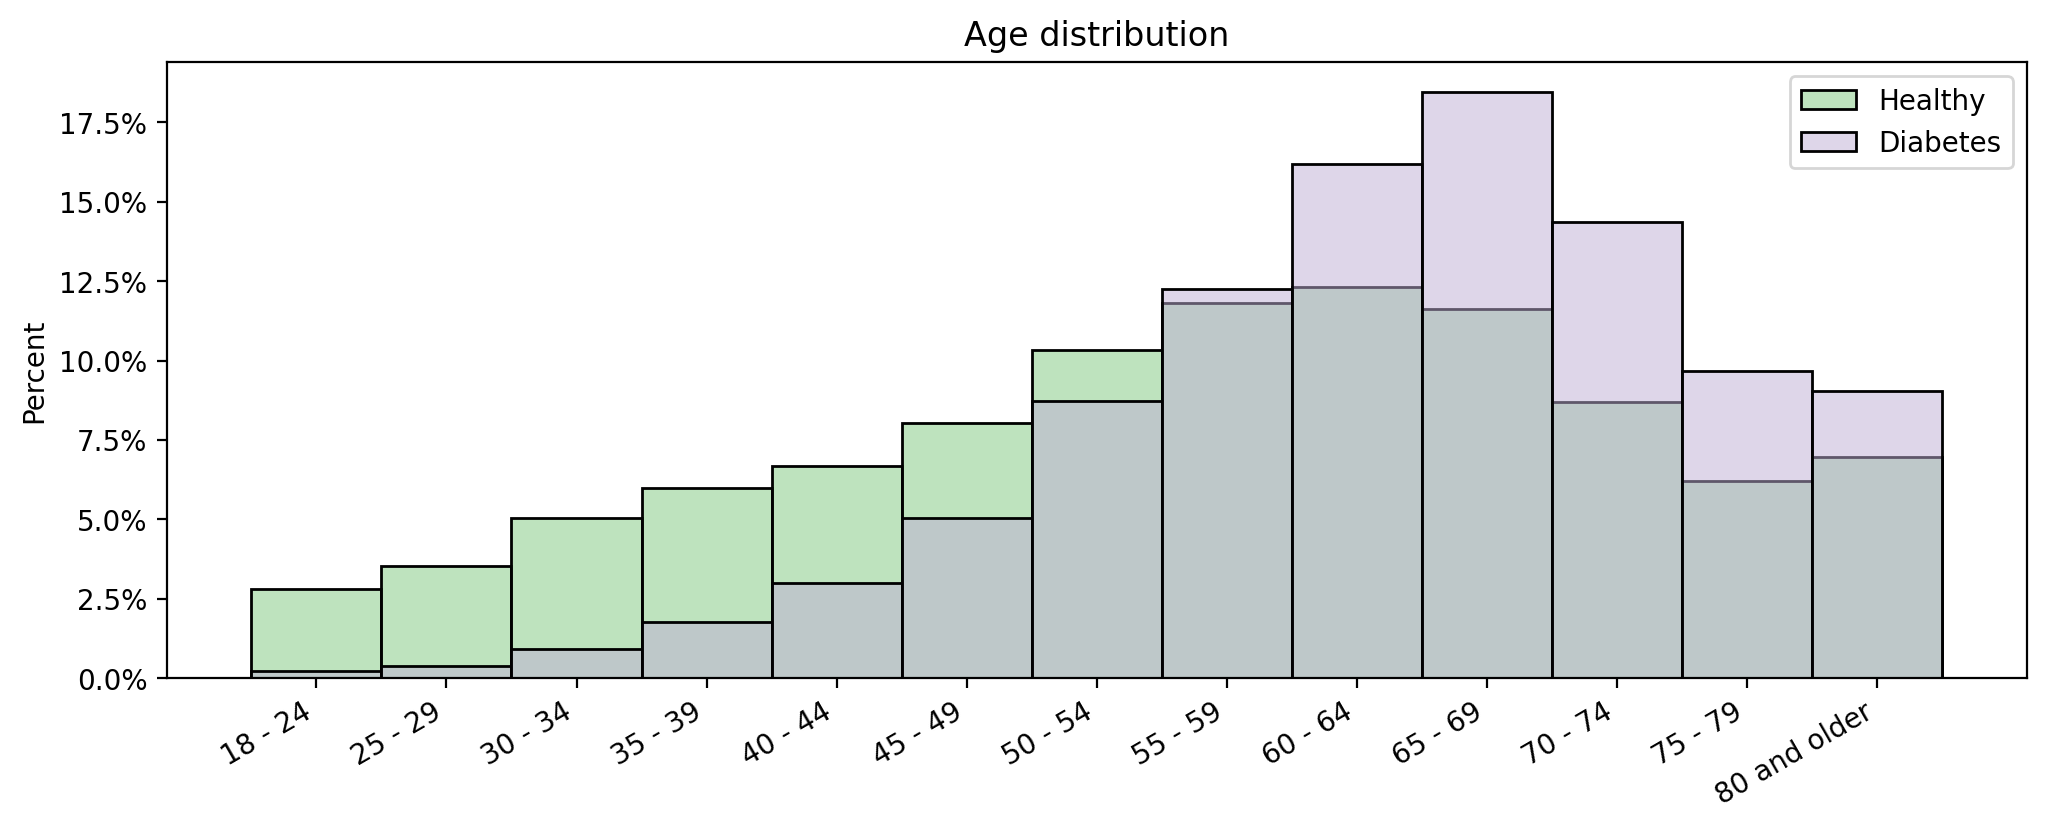

In [43]:
# age categories and diabetis
ex.age_viz(healthy, diabetes)

If I bin the `Age` column, min number of bins should be min 6, as data varies a lot.

#### Feature importance test
For all categorical features I calculate mutual info score and run chi scared statistical test. 

In [15]:
# reduce the number of categories for mental and physical health
df_explore.MentHlth = pd.cut(df_explore.MentHlth, bins=3, labels=['low', 'medium', 'high'])
df_explore.PhysHlth = pd.cut(df_explore.PhysHlth, bins=3, labels=['low', 'medium', 'high'])

The data frame below shows mutual info scores and p-values for each categorical feature. All p-values show significance, however, mutual info scores are very low for some categories.

In [16]:
# show stat tests results
stat_values = ex.stat_categorical(df_explore, 'Diabetes')
stat_values

,mi,P_value,is_significant
GenHlth,0.040,0.000,True
HighBP,0.033,0.000,True
Age,0.021,0.000,True
HighChol,0.019,0.000,True
DiffWalk,0.019,0.000,True
HeartDiseaseorAttack,0.011,0.000,True
Income,0.010,0.000,True
PhysHlth,0.009,0.000,True
Education,0.005,0.000,True
PhysActivity,0.005,0.000,True


In [17]:
# 5 columns with the smalles mi score will be dropped
stat_values[-5:].index.to_list()

['Veggies', 'Sex', 'Fruits', 'AnyHealthcare', 'NoDocbcCost']

Check if lowering the number of age categories increases mutual info score.

In [21]:
# change categories back to numerical
df_explore.Age = pd.Categorical(df_explore.Age, ordered=True)
df_explore.Age = df_explore.Age.cat.rename_categories([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
# bin the categories
df_explore.Age = pd.cut(df_explore.Age, bins=5, labels = [1, 2, 3, 4, 5])
# check the score
ex.stat_categorical(df_explore, 'Diabetes').loc['Age', 'mi']

0.019864020422751982

The score decreases, I leave the `Age` column without changes.

### Data cleaning, feature engineering and preprocessing

Based on the results of the data exploration, the following data preprocessing steps will be performed:
1. Cleaning: Drop the columns `Veggies`, `Sex`, `Fruits`, `AnyHealthcare`, and `NoDocbcCost`. All other nominal data will remain unchanged.
2. Feature engineering: Reduce the number of ordered categories in `MentHlth` and `PhysHlth` and encode them using `OneHotEncoder`.
3. The other ordinal data, such as `GenHlth`, `Age`, `Education`, and `Income`, will remain with number encoding.
4. The BMI will remain a continuous variable without any categorical data engineering involved.

You can find all the relevant code in the `data_prep.py` file, functions `clean_data`, `split_data`, `get_X`

In [197]:
train, validate, test, y_train, y_val, y_test = dp.split_data(df)

In [198]:
# check the length of data sets
train.shape[0], validate.shape[0], test.shape[0]

(137684, 45895, 45895)

In [199]:
# data after cleaning
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137684 entries, 0 to 137683
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   HighBP                137684 non-null  uint8   
 1   HighChol              137684 non-null  uint8   
 2   CholCheck             137684 non-null  uint8   
 3   BMI                   137684 non-null  uint8   
 4   Smoker                137684 non-null  uint8   
 5   Stroke                137684 non-null  uint8   
 6   HeartDiseaseorAttack  137684 non-null  uint8   
 7   PhysActivity          137684 non-null  uint8   
 8   HvyAlcoholConsump     137684 non-null  uint8   
 9   GenHlth               137684 non-null  category
 10  MentHlth              137684 non-null  category
 11  PhysHlth              137684 non-null  category
 12  DiffWalk              137684 non-null  uint8   
 13  Age                   137684 non-null  category
 14  Education             137684 non-nul

In [200]:
train.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,Education,Income
0,0,0,1,22,1,0,0,1,1,1,low,low,0,7,4,8
1,0,1,1,21,1,0,0,1,0,3,low,low,0,12,6,4
2,1,1,1,26,0,0,0,1,0,4,low,medium,1,9,4,1
3,0,0,1,28,1,0,0,1,0,2,low,low,0,8,6,7
4,0,0,1,24,0,0,0,1,0,4,low,low,0,9,6,8


### Model evaluation

<details><summary><i>Expand</i></summary>

> For model evaluation I use __*recall score*__. It is less costly to falsely identify someone as sick or high-risk than it is to falsely identify someone as healthy and miss the opportunity to start early treatment. Therefore, in this case recall is a more reliable indicator of accuracy.

> $Recall = \frac{TruePositive}{TruePositive + FalseNegative}$ 

__Recall__ ranges from 0 to 1 and tells us how well our model does at recognizing the actually positve cases. 

For example, if we predict that __all patients__ are healthy (`Diabetes_binary = 0`), recall score will be equal to 0 because we didn't predict correct any case of diabetis.

```python
>>> recall_score(y_val, np.zeros(len(y_val)), zero_division=0)
0.0
```

If we predict that everyone has diabetes (`Diabetes_binary = 1`), recall score will be equal to one, as we haven't make any errors in predictions of people with diabetes.
```python
>>> recall_score(y_train, np.ones(len(y_train)))
1.0
```

Like in the example above we can get the perfect recall score equal to one just by assigning the positive diagnosis for all patients. This doesn't make the machine learning model good, that's why we need to take into consideration other metrics, too. 

In my evaluation I'll pay attention to `precision`, `f1 score` and `auc score`.
- __Precision__ tells us how many people that we predicted to have diabetes really have diabetes.
- __F1 score__ tells how good are positive predictions.
- __AUC score__ shows the overall fit of predictions. The `auc` score below 0.5 will alarm that the model makes more incorrect predictions that correct ones.

</details>

In [202]:
print(f'{"Precision score for everyone predicted healthy:":<50}{precision_score(y_val, np.zeros(len(y_val)), zero_division=0): >3}')
print(f'{"Precision score for everyone predicted sick:":<50}{precision_score(y_val, np.ones(len(y_val))).round(2): >3}')
print(f'{"F1 score for everyone predicted healthy:":<50}{f1_score(y_val, np.zeros(len(y_val))): >3}')
print(f'{"F1 score for everyone predicted sick:":<50}{f1_score(y_val, np.ones(len(y_val))).round(2): >3}')
print(f'{"AUC score for everyone predicted healthy:":<50}{roc_auc_score(y_val, np.zeros(len(y_val))): >3}')
print(f'{"AUC score for everyone predicted sick:":<50}{roc_auc_score(y_val, np.ones(len(y_val))): >3}')


Precision score for everyone predicted healthy:   0.0
Precision score for everyone predicted sick:      0.16
F1 score for everyone predicted healthy:          0.0
F1 score for everyone predicted sick:             0.27
AUC score for everyone predicted healthy:         0.5
AUC score for everyone predicted sick:            0.5


<div class="alert alert-success">

### Modeling

In [203]:
# prepare data for the model
X_train, X_validate, X_test = dp.get_X(train, validate, test)

<div class="alert alert-warning">

### Baseline model


I create a baseline model with random probabilities of getting diabetes. It serves as a point of reference agianst which the performance of machine learning models is measured. 

In [204]:
# create a baseline model
np.random.seed(dp.seed)
y_rand = np.random.uniform(0, 1, size=len(y_val))
print(f'{"Random model Precision:":<25}{precision_score(y_val, y_rand >= 0.5).round(2): >5}')
print(f'{"Random model Recall:":<25}{recall_score(y_val, y_rand >= 0.5).round(2): >5}')
print(f'{"Random model F1 score:":<25}{f1_score(y_val, y_rand >= 0.5).round(2): >5}')
print(f'{"Random model AUC score:":<25}{roc_auc_score(y_val, y_rand).round(2): >5}')


Random model Precision:   0.15
Random model Recall:      0.49
Random model F1 score:    0.23
Random model AUC score:   0.49


My first modeling iteration with the `RandomForestClassifier` showed very bad results. Accuracy of the model is 82%, which is lower than predicting for everyone to be healthy. In this case accuracy will be equal to the proportion of healthy people in our data - 84.7%. The recall score is 28%, which is 21% lower that the random model has. You can see that information below in the classification report.

In [205]:
# create a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, random_state=dp.seed)
# fit
rf.fit(X_train, y_train)
# predict
y_pred = rf.predict_proba(X_validate)[:, 1]
# print classification report with scores and AUC score
print(md.get_report(y_val, y_pred))

              precision    recall  f1-score

           1       0.39      0.28      0.32

    accuracy                           0.82
         auc                           0.73


### Data cleaning, feature engineering and preprocessing II

I made an attempt to improve the model by tuning it, but it didn't result in any significant improvements. Thus, I decided to modify the preprocessing part of the data.

Here are the changes that were made:

1. The most important modification was __balancing__ the data. Now, there are 50% people with diabetes and 50% without. The size of data set decreased.
2. `BMI` have been converted from a continuous variable to a categorical one. Two new columns have been created: `BMI_under` (for those whose BMI is equal to or lower than 18, with a value of 1, and 0 for the rest) and `BMI_over` (for those whose BMI is equal to or higher than 25, with a value of 1, and 0 for the rest). Respondents with a `normal BMI` receive a value of 0 in both columns.
3. All ordinal categories have been encoded using `One Hot Encoder`. 

As a result a recall score went from 0.28 to 0.72 and other scores were improved as well.

In [5]:
# reassign variables with balanced data
train, validate, test, y_train, y_val, y_test = dp.split_data(df, balance=True)
train.shape[0], validate.shape[0], test.shape[0]

(42116, 14039, 14039)

In [207]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42116 entries, 0 to 42115
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   HighBP                42116 non-null  uint8   
 1   HighChol              42116 non-null  uint8   
 2   CholCheck             42116 non-null  uint8   
 3   BMI                   42116 non-null  uint8   
 4   Smoker                42116 non-null  uint8   
 5   Stroke                42116 non-null  uint8   
 6   HeartDiseaseorAttack  42116 non-null  uint8   
 7   PhysActivity          42116 non-null  uint8   
 8   HvyAlcoholConsump     42116 non-null  uint8   
 9   GenHlth               42116 non-null  category
 10  MentHlth              42116 non-null  category
 11  PhysHlth              42116 non-null  category
 12  DiffWalk              42116 non-null  uint8   
 13  Age                   42116 non-null  category
 14  Education             42116 non-null  category
 15  In

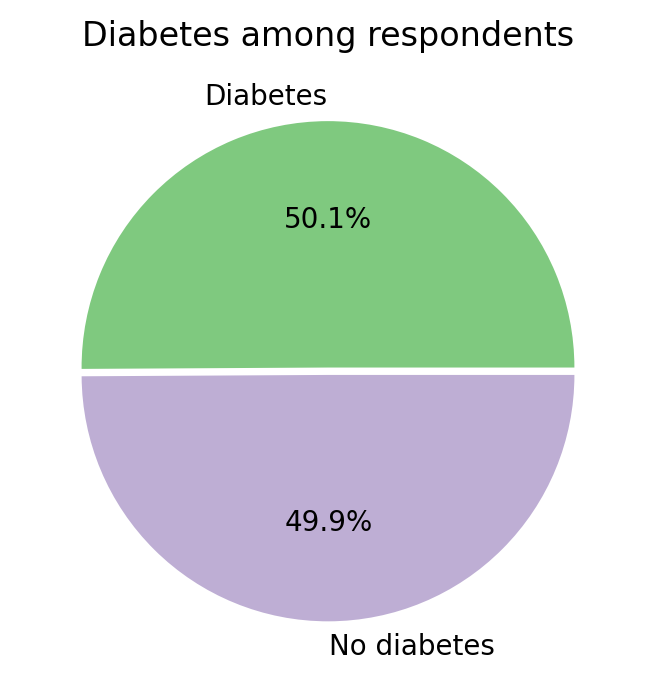

In [222]:
# visualize target variable balance in train data
ex.diabetes_piechart_ytrain(y_train)

In [10]:
# recalculate scores for data when everyone is sick or everyone is healthy
print("Everyone is predicted healthy")
print(f'{"Precision score:":<50}{precision_score(y_val, np.zeros(len(y_val)), zero_division=0): >3}')
print(f'{"F1 score:":<50}{f1_score(y_val, np.zeros(len(y_val))): >3}')
print(f'{"AUC score:":<50}{roc_auc_score(y_val, np.zeros(len(y_val))): >3}')
print("===============")
print()
print("Everyone is predicted sick")
print(f'{"Precision when every one is predicted sick:":<50}{precision_score(y_val, np.ones(len(y_val))).round(2): >3}')
print(f'{"F1 score when every one is predicted sick:":<50}{f1_score(y_val, np.ones(len(y_val))).round(2): >3}')
print(f'{"AUC score when every one is predicted sick:":<50}{roc_auc_score(y_val, np.ones(len(y_val))): >3}')

Everyone is predicted healthy
Precision score:                                  0.0
F1 score:                                         0.0
AUC score:                                        0.5

Everyone is predicted sick
Precision when every one is predicted sick:       0.5
F1 score when every one is predicted sick:        0.66
AUC score when every one is predicted sick:       0.5


In [223]:
# recreate a basline model save and print scores
np.random.seed(dp.seed)
y_rand = np.random.uniform(0, 1, size=len(y_val))
# calculate baseline scores
baseline_precision = precision_score(y_val, y_rand >= 0.5)
basline_recall = recall_score(y_val, y_rand >= 0.5)
baseline_f1 = f1_score(y_val, y_rand >= 0.5)
baseline_auc = roc_auc_score(y_val, y_rand)
# preint results
print(f'{"Random model Accuracy:":<25}{accuracy_score(y_val, y_rand >= 0.5).round(2): >5}')
print(f'{"Random model Precision:":<25}{baseline_precision.round(2): >5}')
print(f'{"Random model Recall:":<25}{basline_recall.round(2): >5}')
print(f'{"Random model F1 score:":<25}{baseline_f1.round(2): >5}')
print(f'{"Random model AUC score:":<25}{baseline_auc.round(2): >5}')

Random model Accuracy:    0.51
Random model Precision:    0.5
Random model Recall:      0.51
Random model F1 score:    0.51
Random model AUC score:   0.51


In [6]:
# reassign X_train, X_validate, X_test
X_train, X_validate, X_test = dp.get_X_ohe(train, validate, test)
X_train.shape, X_validate.shape, X_test.shape

((42116, 43), (14039, 43), (14039, 43))

In [225]:
# repeat modeling and print classification report
# create a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, random_state=dp.seed)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_validate)[:, 1]
# print classification report with scores and AUC score
print(md.get_report(y_val, y_pred))

              precision    recall  f1-score

           1       0.67      0.72      0.69

    accuracy                           0.68
         auc                           0.74


Our main evaluation metric - recall, went from 0.28 to 0.72. This is a huge improvement. 

<div class="alert alert-success">

### Random Forest Tuning

#### Find the optimal threshold.

In [226]:
thresholds = np.linspace(0, 1, 11)
scores = [("baseline", baseline_precision, basline_recall, baseline_f1, baseline_auc)]
for t in thresholds:
    rf = RandomForestClassifier(n_estimators=10, random_state=dp.seed)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_validate)[:, 1]
    precision = precision_score(y_val, y_pred >= t)
    recall = recall_score(y_val, y_pred >= t)
    f1 = f1_score(y_val, y_pred >= t)
    auc = roc_auc_score(y_val, y_pred)
    scores.append((t, precision, recall, f1, auc))
df_scores = pd.DataFrame(scores, columns=["thresholds", "precision", "recall", "f1_score", "auc_score"])
df_scores

,thresholds,precision,recall,f1_score,auc_score
0,baseline,0.503,0.508,0.505,0.505
1,0.000,0.497,1.000,0.664,0.736
2,0.100,0.555,0.954,0.702,0.736
3,0.200,0.586,0.913,0.714,0.736
4,0.300,0.625,0.840,0.716,0.736
5,0.400,0.643,0.803,0.714,0.736
6,0.500,0.667,0.722,0.693,0.736
7,0.600,0.697,0.573,0.629,0.736
8,0.700,0.723,0.442,0.549,0.736
9,0.800,0.737,0.387,0.507,0.736


The best balance between all scores is achieved with the threshold equal to 0.4, meanwhile the threshold set to 0.5 also performs good.

#### Tune `max_depth`

In [243]:
scores = []
for t in [0.4, 0.5]:
    for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
        rf = RandomForestClassifier(n_estimators=10, max_depth=d, random_state=dp.seed)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_validate)[:, 1]
        precision = precision_score(y_val, y_pred >= t)
        recall = recall_score(y_val, y_pred >= t)
        f1 = f1_score(y_val, y_pred >= t)
        auc = roc_auc_score(y_val, y_pred)
        scores.append((round(t, 1), d, precision, recall, f1, auc))
df_scores = pd.DataFrame(scores, columns=["thresholds", "max_depth", "precision", "recall", "f1_score", "auc_score"])

In [245]:
df_scores.sort_values(by=["auc_score", "recall"], ascending=False).head()

,thresholds,max_depth,precision,recall,f1_score,auc_score
6,0.400,10.000,0.658,0.866,0.748,0.797
16,0.500,10.000,0.708,0.768,0.737,0.797
7,0.400,15.000,0.663,0.856,0.747,0.791
17,0.500,15.000,0.700,0.761,0.730,0.791
4,0.400,5.000,0.642,0.875,0.741,0.789


The best results are with `threshold=0.4` and `max_depth=10`

#### Tune `min_samples_leaf`

In [246]:
scores = []
for t in [0.4, 0.5]:
    for d in [6, 10, 15]:
        for s in [1, 2, 5, 10, 15, 20, 50, 100, 200, 500]:
            rf = RandomForestClassifier(
                n_estimators=10, 
                max_depth = d,
                min_samples_leaf = s,
                random_state=dp.seed)
            rf.fit(X_train, y_train)
            y_pred = rf.predict_proba(X_validate)[:, 1]
            precision = precision_score(y_val, y_pred >= t)
            recall = recall_score(y_val, y_pred >= t)
            f1 = f1_score(y_val, y_pred >= t)
            auc = roc_auc_score(y_val, y_pred)
            scores.append((t, d, s, precision, recall, f1, auc))
df_scores = pd.DataFrame(scores, columns=["thresholds", "max_depth", "min_samples_leaf", "precision", "recall", "f1_score", "auc_score"])

In [250]:
# sort by recall
df_scores.sort_values(by=["recall"], ascending=False).head(3)

,thresholds,max_depth,min_samples_leaf,precision,recall,f1_score,auc_score
3,0.400,6,10,0.648,0.880,0.746,0.790
4,0.400,6,15,0.646,0.880,0.745,0.790
6,0.400,6,50,0.647,0.876,0.745,0.790


In [251]:
# sort by auc score
df_scores.sort_values("auc_score", ascending=False).head(3)

,thresholds,max_depth,min_samples_leaf,precision,recall,f1_score,auc_score
54,0.500,15,15,0.706,0.769,0.736,0.799
24,0.400,15,15,0.665,0.865,0.752,0.799
53,0.500,15,10,0.710,0.768,0.738,0.799


#### Tune `min_samples_split`.

In [256]:
scores = []
for t in [0.4, 0.5]:
        for d in [6, 10, 15]:
                for m in [10, 15]:
                        for split in [0.1, 0.2, 0.3, 0.4, 0.5, 2, 4, 5, 10, 50, 100]:
                                rf = RandomForestClassifier(
                                        n_estimators=10, 
                                        max_depth = d,
                                        min_samples_leaf = m,
                                        min_samples_split=split,
                                        random_state=dp.seed)
                                rf.fit(X_train, y_train)
                                y_pred = rf.predict_proba(X_validate)[:, 1]
                                precision = precision_score(y_val, y_pred >= t)
                                recall = recall_score(y_val, y_pred >= t)
                                f1 = f1_score(y_val, y_pred >= t)
                                auc = roc_auc_score(y_val, y_pred)
                                scores.append((t, d, m, split, precision, recall, f1, auc))
df_scores = pd.DataFrame(scores, columns=["threshold", "max_depth", "min_samples_leaf", "min_samples_split", "precision", "recall", "f1_score", "auc_score"])

In [260]:
df_scores.sort_values(by=["recall"], ascending=False).head(3)

,threshold,max_depth,min_samples_leaf,min_samples_split,precision,recall,f1_score,auc_score
48,0.400,15,10,0.500,0.598,0.905,0.720,0.757
59,0.400,15,15,0.500,0.598,0.905,0.720,0.757
26,0.400,10,10,0.500,0.598,0.905,0.720,0.757


In [261]:
df_scores.sort_values("auc_score", ascending=False).head(3)

,threshold,max_depth,min_samples_leaf,min_samples_split,precision,recall,f1_score,auc_score
62,0.400,15,15,5.000,0.665,0.865,0.752,0.799
127,0.500,15,15,4.000,0.706,0.769,0.736,0.799
129,0.500,15,15,10.000,0.706,0.769,0.736,0.799


In [262]:
df_scores.sort_values(by="f1_score", ascending=False).head(3)

,threshold,max_depth,min_samples_leaf,min_samples_split,precision,recall,f1_score,auc_score
60,0.400,15,15,2.000,0.665,0.865,0.752,0.799
61,0.400,15,15,4.000,0.665,0.865,0.752,0.799
62,0.400,15,15,5.000,0.665,0.865,0.752,0.799


Although some models return almost ideal recall (`0.9`), their precision score is very low (`0.6`). This means that almost half of the people identified as sick with diabetes are falsely identified. `min_samples_split = 0.5` should not be used for next model tuning.

####  Tune `n_estimators`

In [274]:
scores = []
t = 0.4 # threshold
for d in [6, 10, 15]:
        for m in [10, 15]:
                for split in [2, 5]:
                        for n in [5, 10, 15, 20, 50, 100, 200, 500]:
                                rf = RandomForestClassifier(
                                        n_estimators=n, 
                                        max_depth = d,
                                        min_samples_leaf = m,
                                        min_samples_split=split,
                                        n_jobs=-1, # speed up the process
                                        random_state=dp.seed)
                                rf.fit(X_train, y_train)
                                y_pred = rf.predict_proba(X_validate)[:, 1]
                                precision = precision_score(y_val, y_pred >= t)
                                recall = recall_score(y_val, y_pred >= t)
                                f1 = f1_score(y_val, y_pred >= t)
                                auc = roc_auc_score(y_val, y_pred)
                                scores.append((d, m, split, n, precision, recall, f1, auc))
df_scores = pd.DataFrame(scores, columns=["max_depth", "min_samples_leaf", "min_samples_split", "n_estimators", "precision", "recall", "f1_score", "auc_score"])

In [278]:
df_scores.sort_values("recall", ascending=False).head(3)

,max_depth,min_samples_leaf,min_samples_split,n_estimators,precision,recall,f1_score,auc_score
28,6,15,5,50,0.644,0.886,0.746,0.793
20,6,15,2,50,0.644,0.886,0.746,0.793
30,6,15,5,200,0.644,0.885,0.745,0.793


In [281]:
df_scores.sort_values("f1_score", ascending=False).head(3)

,max_depth,min_samples_leaf,min_samples_split,n_estimators,precision,recall,f1_score,auc_score
76,15,10,5,50,0.667,0.868,0.754,0.802
68,15,10,2,50,0.667,0.868,0.754,0.802
69,15,10,2,100,0.664,0.872,0.754,0.802


In [280]:
df_scores.sort_values("auc_score", ascending=False).head(3)

,max_depth,min_samples_leaf,min_samples_split,n_estimators,precision,recall,f1_score,auc_score
77,15,10,5,100,0.664,0.872,0.754,0.802
69,15,10,2,100,0.664,0.872,0.754,0.802
76,15,10,5,50,0.667,0.868,0.754,0.802


In [286]:
scores = []
for n in  [50, 60, 70, 80, 90, 100]:
    rf = RandomForestClassifier(
            n_estimators=n, 
            max_depth = 15,
            min_samples_leaf = 10,
            min_samples_split=5,
            n_jobs=-1, # speed up the process
            random_state=dp.seed)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_validate)[:, 1]
    precision = precision_score(y_val, y_pred >= t)
    recall = recall_score(y_val, y_pred >= t)
    f1 = f1_score(y_val, y_pred >= t)
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, precision, recall, f1, auc))
df_scores = pd.DataFrame(scores, columns=["n_estimators", "precision", "recall", "f1_score", "auc_score"])

In [287]:
df_scores

,n_estimators,precision,recall,f1_score,auc_score
0,50,0.667,0.868,0.754,0.802
1,60,0.665,0.870,0.754,0.802
2,70,0.664,0.869,0.753,0.802
3,80,0.664,0.871,0.754,0.802
4,90,0.663,0.871,0.753,0.802
5,100,0.664,0.872,0.754,0.802


The best parameters are:
- `n_estimators = 100`
- `max_depth = 15`
- `min_samples_leaf = 10`
- `min_samples_split = 5`

Create the best Random Forest model and print the classification report.

In [301]:
rf = RandomForestClassifier(
        n_estimators=100, 
        max_depth = 15,
        min_samples_leaf = 10,
        min_samples_split=5,
        n_jobs=-1, # speed up the process
        random_state=dp.seed)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_validate)[:, 1]
print(md.get_report(y_val, y_pred, threshold=0.4))

              precision    recall  f1-score

           1       0.66      0.87      0.75

    accuracy                           0.72
         auc                           0.8


<div class="alert alert-success">

### Tuning XGBoost

In [302]:
features = dp.get_X_ohe(train, validate, test, get_features=True)
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_validate, label=y_val, feature_names=features)

In [303]:
# set parameters to pass to xgboost
xgb_params = {
    'eta': 0.3, # learning rate
    'max_depth': 6,
    'min_child_weight': 1, # min_samples_leaf

    'objective': 'binary:logistic', # specify that we have a binary classification model
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': dp.seed,
    'verbosity': 1 # show the process 0, 1, 2
}

In [304]:
model = xgb.train(xgb_params, dtrain, num_boost_round=20)
# check predictions with treshold 0.5
y_pred = model.predict(dval)
print(md.get_report(y_val, y_pred))


              precision    recall  f1-score

           1       0.71      0.77      0.74

    accuracy                           0.73
         auc                           0.8


In [307]:
# check predictions with threshold 0.45
y_pred = model.predict(dval)
print(md.get_report(y_val, y_pred, threshold = 0.45))

              precision    recall  f1-score

           1       0.69      0.82      0.75

    accuracy                           0.73
         auc                           0.8


In [306]:
# check predictions with threshold 0.4
y_pred = model.predict(dval)
print(md.get_report(y_val, y_pred, threshold = 0.4))

              precision    recall  f1-score

           1       0.67      0.86      0.75

    accuracy                           0.72
         auc                           0.8


XGBoost with starting parameters and threshold set to 0.4 gives the almost the same recall, precision and f1 scores as the best Random Forest model. Let's see if tuning parameters can improve the score.

In [308]:
# create a watchlist for the xgboost model to see the score change
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [316]:
%%capture output
model = xgb.train(xgb_params, 
                    dtrain, 
                    evals=watchlist, # to print train and val sets auc score
                    verbose_eval = 5, # to print out only every 5th step
                    num_boost_round=200)

In [320]:
xgb_scores = md.parse_xgb_output(output)
xgb_scores.sort_values(by='score_diff').head()

,iteration,train_score,validation_score,score_diff
0,0,0.776,0.776,-0.001
1,5,0.799,0.797,0.002
2,10,0.807,0.800,0.007
3,15,0.811,0.801,0.010
4,20,0.815,0.801,0.014


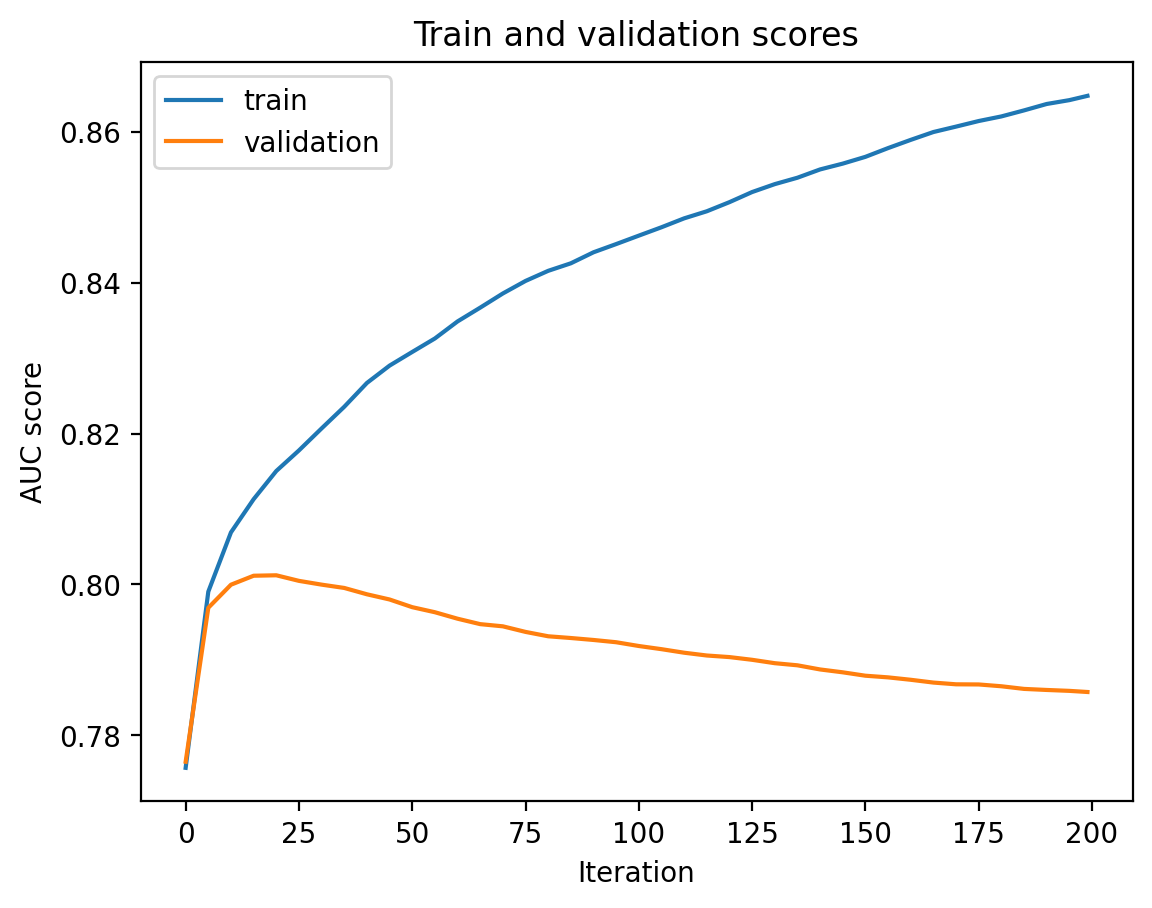

In [322]:
plt.plot(xgb_scores.iteration, xgb_scores.train_score, label='train')
plt.plot(xgb_scores.iteration, xgb_scores.validation_score, label='validation')
plt.xlabel("Iteration")
plt.ylabel("AUC score")
plt.title("Train and validation scores")
plt.legend()
plt.show()

In [314]:
# it has good validation score and smaller difference between train and validation score
# means the model has less chances to overfit
num_boost_round=10

In [323]:
model = xgb.train(xgb_params, 
                    dtrain, 
                    evals=watchlist,
                    verbose_eval = 5,
                    num_boost_round=num_boost_round)

[0]	train-auc:0.77567	val-auc:0.77648
[5]	train-auc:0.79904	val-auc:0.79690
[10]	train-auc:0.80690	val-auc:0.79996
[14]	train-auc:0.81058	val-auc:0.80104


In [325]:
y_pred = model.predict(dval)
print(md.get_report(y_val, y_pred))

              precision    recall  f1-score

           1       0.71      0.77      0.74

    accuracy                           0.73
         auc                           0.8


In [326]:
print(md.get_report(y_val, y_pred, threshold=0.4))

              precision    recall  f1-score

           1       0.67      0.86      0.75

    accuracy                           0.72
         auc                           0.8


#### Tune learning rate `eta`.

In [340]:
scores = []
for t in [0.4, 0.5]:
    for eta in [0.001, 0.1, 0.3, 0.5, 0.7, 1]:
        xgb_params = {
                'eta': eta, # learning rate
                'max_depth': 6,
                'min_child_weight': 1, # min_samples_leaf

                'objective': 'binary:logistic', # specify that we have a binary classification model
                'eval_metric': 'auc',
                'nthread': 8,
                'seed': dp.seed,
                'verbosity': 1 # show the process 0, 1, 2
        }
        model = xgb.train(xgb_params, dtrain, num_boost_round=10)
        y_pred = model.predict(dval)
        precision = precision_score(y_val, y_pred >= t)
        recall = recall_score(y_val, y_pred >= t)
        f1 = f1_score(y_val, y_pred >= t)
        auc = roc_auc_score(y_val, y_pred)
        scores.append((t, eta, precision, recall, f1, auc))
df_scores = pd.DataFrame(scores, columns=["thresholds", "eta", "precision", "recall", "f1_score", "auc_score"])

In [341]:
pd.concat([
    df_scores.sort_values(by="recall", ascending=False).head(3),
    df_scores.sort_values(by="f1_score", ascending=False).head(3),
    df_scores.sort_values(by="auc_score", ascending=False).head(3)
])

,thresholds,eta,precision,recall,f1_score,auc_score
0,0.400,0.001,0.497,1.000,0.664,0.777
1,0.400,0.100,0.640,0.891,0.744,0.793
2,0.400,0.300,0.666,0.865,0.753,0.800
2,0.400,0.300,0.666,0.865,0.753,0.800
3,0.400,0.500,0.670,0.856,0.752,0.799
4,0.400,0.700,0.670,0.857,0.752,0.797
2,0.400,0.300,0.666,0.865,0.753,0.800
8,0.500,0.300,0.709,0.768,0.738,0.800
3,0.400,0.500,0.670,0.856,0.752,0.799


`eta = 0.1` returns perfect recall, but the precision score is very low, these results can not be taken into consideration. The best `eta` stays with the value `0.3`.

Tune `max_depth`.

In [342]:
scores = []
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    xgb_params = {
            'eta': 0.3, # learning rate
            'max_depth': d,
            'min_child_weight': 1, # min_samples_leaf

            'objective': 'binary:logistic', # specify that we have a binary classification model
            'eval_metric': 'auc',
            'nthread': 8,
            'seed': dp.seed,
            'verbosity': 1 # show the process 0, 1, 2
    }
    model = xgb.train(xgb_params, dtrain, num_boost_round=10)
    y_pred = model.predict(dval) 
    precision = precision_score(y_val, y_pred >= 0.4)
    recall = recall_score(y_val, y_pred >= 0.4)
    f1 = f1_score(y_val, y_pred >= 0.4)
    auc = roc_auc_score(y_val, y_pred)
    scores.append((d, precision, recall, f1, auc))
df_scores = pd.DataFrame(scores, columns=["max_depth",  "precision", "recall", "f1_score", "auc_score"])

In [343]:
df_scores

,max_depth,precision,recall,f1_score,auc_score
0,1.000,0.635,0.873,0.735,0.775
1,2.000,0.635,0.883,0.738,0.784
2,3.000,0.656,0.868,0.747,0.793
3,4.000,0.659,0.869,0.749,0.798
4,5.000,0.662,0.863,0.749,0.799
5,6.000,0.666,0.865,0.753,0.800
6,10.000,0.668,0.856,0.751,0.796
7,15.000,0.666,0.843,0.744,0.783
8,20.000,0.660,0.821,0.732,0.773
9,NaN,0.666,0.865,0.753,0.800


`max_depth` stays equal to 6

#### Tune `min_child_weight`

In [344]:
scores = []
for w in [1, 2, 5, 10, 15, 20, 50, 100, 200, 500]:
    xgb_params = {
            'eta': 0.3, # learning rate
            'max_depth': 6,
            'min_child_weight': w, # min_samples_leaf

            'objective': 'binary:logistic', # specify that we have a binary classification model
            'eval_metric': 'auc',
            'nthread': 8,
            'seed': dp.seed,
            'verbosity': 1 # show the process 0, 1, 2
    }
    model = xgb.train(xgb_params, dtrain, num_boost_round=10)
    y_pred = model.predict(dval)
    precision = precision_score(y_val, y_pred  >= 0.4)
    recall = recall_score(y_val, y_pred  >= 0.4)
    f1 = f1_score(y_val, y_pred  >= 0.4)
    auc = roc_auc_score(y_val, y_pred)
    scores.append((w, precision, recall, f1, auc))
df_scores = pd.DataFrame(scores, columns=["min_child_weight",  "precision", "recall", "f1_score", "auc_score"])

In [345]:
df_scores

,min_child_weight,precision,recall,f1_score,auc_score
0,1,0.666,0.865,0.753,0.800
1,2,0.670,0.859,0.753,0.800
2,5,0.667,0.864,0.753,0.801
3,10,0.671,0.858,0.753,0.800
4,15,0.672,0.862,0.755,0.801
5,20,0.672,0.856,0.752,0.801
6,50,0.663,0.870,0.752,0.802
7,100,0.665,0.862,0.750,0.801
8,200,0.665,0.869,0.753,0.801
9,500,0.661,0.861,0.748,0.795


`min_child_weight = 50` improves `recall` and `auc` scores

#### Final XGBoos model

In [346]:
xgb_params = {
        'eta': 0.3, # learning rate
        'max_depth': 6,
        'min_child_weight': 50, # min_samples_leaf
        'objective': 'binary:logistic', # specify that we have a binary classification model
        'eval_metric': 'auc',
        'nthread': 8,
        'seed': dp.seed,
        'verbosity': 1 # show the process 0, 1, 2
}
model = xgb.train(xgb_params, dtrain, num_boost_round=10)
y_pred = model.predict(dval)
print(md.get_report(y_val, y_pred, 0.4))

              precision    recall  f1-score

           1       0.66      0.87      0.75

    accuracy                           0.72
         auc                           0.8


Compare to final Random Forest model

In [360]:
rf = RandomForestClassifier(
        n_estimators=500, 
        max_depth = 10,
        min_samples_leaf = 10,
        n_jobs=-1, # speed up the process
        random_state=dp.seed
        )
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_validate)[:, 1]
print(md.get_report(y_val, y_pred, 0.4))

              precision    recall  f1-score

           1       0.66      0.87      0.75

    accuracy                           0.72
         auc                           0.8


I have got identical results for both models RandomForestClassifier and XGBoost.

In [7]:
# create concatenate train and validate into one set
X = np.concatenate([X_train, X_validate])
y = np.concatenate([y_train, y_val])

In [370]:
auc_rf = []
auc_xgb = []
recall_rf = []
recall_xgb = []

kfold = KFold(n_splits=10, shuffle=True, random_state=dp.seed)

for train_idx, val_idx in kfold.split(X):
    Xt = X[train_idx]
    Xv = X[val_idx]

    yt = y[train_idx]
    yv = y[val_idx]

    dtrain = xgb.DMatrix(Xt, label=yt, feature_names=features)
    dval = xgb.DMatrix(Xv, label=yv, feature_names=features)

    rf = RandomForestClassifier(
        n_estimators=500, 
        max_depth = 10,
        min_samples_leaf = 10,
        n_jobs=-1, # speed up the process
        random_state=dp.seed
        )
    rf.fit(Xt, yt)
    model = xgb.train(xgb_params, dtrain, num_boost_round=10)

    y_rf = rf.predict_proba(Xv)[:, 1]
    y_xgb = model.predict(dval)

    auc_rf.append(roc_auc_score(yv, y_rf))
    recall_rf.append(recall_score(yv, y_rf >= 0.4))

    auc_xgb.append(roc_auc_score(yv, y_xgb))
    recall_xgb.append(recall_score(yv, y_xgb >= 0.4))
    

In [373]:
print('%s %.3f %s %.3f' % ('Random Forest AUC: Mean', np.mean(auc_rf), 'STD', np.std(auc_rf)))
print('%s %.3f %s %.3f' % ('Random Forest Recall: Mean', np.mean(recall_rf), 'STD', np.std(recall_rf)))
print()
print('%s %.3f %s %.3f' % ('XGBoost AUC: Mean', np.mean(auc_xgb), 'STD', np.std(auc_xgb)))
print('%s %.3f %s %.3f' % ('XGBoost Recall: Mean', np.mean(recall_xgb), 'STD', np.std(recall_xgb)))

Random Forest AUC: Mean 0.794 STD 0.004
Random Forest Recall: Mean 0.866 STD 0.007

XGBoost AUC: Mean 0.797 STD 0.004
XGBoost Recall: Mean 0.864 STD 0.006


I pick `RandomForestClassifier` to my final model that goes to deployment because of slightly higher recall score after performing `KFolds` cross-validation.

<div class="alert alert-success">

### Model Deployment

#### Create and save model

In [8]:
rf = RandomForestClassifier(
    n_estimators=500, 
    max_depth = 10,
    min_samples_leaf = 10,
    n_jobs=-1, # speed up the process
    random_state=dp.seed
    )
rf.fit(X, y)
# check results on the test set
y_pred = rf.predict_proba(X_test)[:, 1]
print(md.get_report(y_test, y_pred, 0.4))

              precision    recall  f1-score

           1       0.66      0.87      0.75

    accuracy                           0.71
         auc                           0.8


In [14]:
# save model to file
model_file = "model.bin"
with open(model_file, "wb") as model_out:
    pickle.dump(rf, model_out)

#### Load and Save `OheHotEncoder`

In [15]:
ohe = dp.get_ohe(train)

In [16]:
ohe

OneHotEncoder(drop='first', sparse=False)

In [17]:
#ohe = dp.get_ohe(train)

encoder_file = "encoder.bin"
with open(encoder_file, "wb") as encoder_out:
    pickle.dump(ohe, encoder_out)

### Create and save `FunctionTransformer`

In [32]:
# create a function that applies custom transormation
def transform_single(patient: dict, ohe= ohe):
    ''' 
    Apply custom transformation.
    Parameters:
        patient: dictionary with respondent's data
        ohe: OneHotEncoder
    '''
    binary = ['HighBP', 'HighChol', 'CholCheck',  'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'HvyAlcoholConsump', 'DiffWalk']
    ordinal = ['MentHlth', 'PhysHlth', 'GenHlth', 'Age', 'Education', 'Income']
    
    bmi = ["BMI_under", "BMI_over"]
   
    def change_values(x, target):
        ''' 
        Function to replace values in MentHlth and PhysHlth columns
        below 10 days -> low, above 20 days -> high, everything else "medium"
        '''
        conds = [x[target] <= 10, x[target] > 20]
        choices = ['low', 'high']
        return np.select(conds, choices, default='medium').astype("object")

    p = pd.DataFrame([patient])
    
    p.MentHlth = change_values(p, 'MentHlth')
    p.PhysHlth = change_values(p, 'PhysHlth')
    p["BMI_under"] = p.BMI.map(lambda x: 1 if x <= 18 else 0)
    p["BMI_over"] = p.BMI.map(lambda x: 1 if x >=25 else 0)
    #p.drop("BMI", axis=1, inplace=True)
    
    return np.concatenate([
        p[binary],
        ohe.transform(p[ordinal]).astype('uint8'),
        p[bmi].astype('uint8')
        ], axis=1)


In [33]:
transformer = FunctionTransformer(transform_single)
transformer

FunctionTransformer(func=<function transform_single at 0x140e144c0>)

In [34]:
# check if transformer works
patient = {'HighBP':1,
 'HighChol':1,
 'CholCheck':1,
 'BMI':25,
 'Smoker':0,
 'Stroke':0,
 'HeartDiseaseorAttack':0,
 'PhysActivity':1,
 'Fruits':1,
 'Veggies':1,
 'HvyAlcoholConsump':1,
 'AnyHealthcare':1,
 'NoDocbcCost':0,
 'GenHlth':4,
 'MentHlth':2,
 'PhysHlth':14,
 'DiffWalk':0,
 'Sex':1,
 'Age':6,
 'Education':6,
 'Income':7}
 
transformer.transform(patient)

array([[1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1]])

In [35]:
# save transformer
transformer_file = "transformer.bin"
with open(transformer_file, "wb") as transformer_out:
    pickle.dump(transformer, transformer_out)

#### Confirm that everythin works

In [36]:
with open(model_file, "rb") as model_in:
    model = pickle.load(model_in)
model

RandomForestClassifier(max_depth=10, min_samples_leaf=10, n_estimators=500,
                       n_jobs=-1, random_state=2912)

In [37]:
with open(encoder_file, "rb") as encoder_in:
    ohe = pickle.load(encoder_in)
ohe

OneHotEncoder(drop='first', sparse=False)

In [38]:
with open(transformer_file, "rb") as transformer_in:
    t = pickle.load(transformer_in)
t

FunctionTransformer(func=<function transform_single at 0x140e144c0>)

In [42]:
model.predict_proba(t.transform(patient))[:, 1][0].round(2)

0.61